# Colocalization classification through ProtoPNet and U-Net Convolutional Neural Networks
### Shiv Gargé, Ria Khera

This project explores the application of ProtoPNet and U-Net Convolutional Neural Networks (CNNs) for colocalization classification in neuro splice images. Colocalization, the spatial overlap of different biological markers within a cell or tissue, is a crucial aspect of understanding cellular functions and disease mechanisms. Traditional methods for colocalization analysis often rely on manual or semi-automated approaches, which can be time-consuming and prone to human error. To address these challenges, we implement a ProtoPNet, which combines the interpretability of prototype learning with the robustness of deep learning, and a U-Net, known for its effectiveness in biomedical image segmentation.

ProtoPNet leverages prototypes to provide interpretable visual explanations for classification decisions, enhancing the transparency of the model (Chen et al., 2019). U-Net, with its encoder-decoder architecture, excels in capturing fine-grained spatial information, making it ideal for segmenting and identifying colocalized regions (Ronneberger et al., 2015). Our integrated approach aims to use U-Net to identify the relevant units (Proteins, Neuros, etc.) through boundary detection. The base DAPI layer will also be included to improve the distinction between noise and relavent intensity signals. Post boundary detection, we will look to overlay the layers with outlined boundaries. This will then be fed into the ProtoPNet model where the colocalization classification takes place.

Additionally, we have variations of this approach that do not use the ProtoPNet model to test for model robustness, compute intensity and accuracy.

*Chen, C., Li, O., Tao, D., Barnett, A., Rudin, C., & Su, J. K. (2019). This looks like that: Deep learning for interpretable image recognition. Advances in Neural Information Processing Systems, 32, 8928-8939.*

*Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional networks for biomedical image segmentation. In International Conference on Medical Image Computing and Computer-Assisted Intervention (pp. 234-241). Springer, Cham.*

## Stage 1 - TIF Image Normalization

To being, we look to automate the image normalization pipeline. This is usualy done manually by feeding the raw TIF into Fuji and then execute a brightness and contrast optimization algorithm. An exposure histogram is a digital bar graph that shows the amount of light in each level of an image. In fuji, it displays a histogram where after the 'optimization' the bounds of the brightness. We will start by building a function to provide batch brightness and contrast normalization.

1.1 - Load Dependencies

In [57]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import exposure
import cv2

1.2.1 - Defining Function and Parameters (Brightness and Contrast Tester)

Test different brightness and contrast settings on an image and display their histograms.
    
Parameters:
* image_path (str): Path to the image file.
* brightness_factors (list): List of brightness factors to test.
* contrast_factors (list): List of contrast factors to test.

In [44]:
def brightness_contrast_tester(image_path, brightness_factors, contrast_factors):

    for filename in os.listdir(image_path):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            file_path = os.path.join(image_path, filename)
            image = Image.open(file_path)
            image_array = np.array(image)
            
            if len(image_array.shape) == 3 and image_array.shape[2] == 4:
                blue_channel = image_array[:, :, 2]
                blue_channel_enhanced = (blue_channel - blue_channel.min()) / (blue_channel.max() - blue_channel.min()) * 255
                blue_channel_enhanced = blue_channel_enhanced.astype(np.uint8)
                enhanced_image_array = np.zeros_like(image_array)
                enhanced_image_array[:, :, 2] = blue_channel_enhanced
                enhanced_image_array[:, :, 3] = 255
                enhanced_image = Image.fromarray(enhanced_image_array)
            else:
                enhanced_image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255
                enhanced_image_array = enhanced_image_array.astype(np.uint8)
                enhanced_image = Image.fromarray(np.stack((enhanced_image_array,) * 3, axis=-1))
                enhanced_image = enhanced_image.convert("RGBA")
            
            # Ensure image is compatible
            if enhanced_image.mode not in ["RGB", "RGBA"]:
                enhanced_image = enhanced_image.convert("RGB")
            
            fig, axes = plt.subplots(len(brightness_factors)*2, len(contrast_factors), figsize=(15, 30))
            plt.suptitle(f'Brightness and Contrast Adjustments with Normalized Histograms for {filename}')
            
            for i, b_factor in enumerate(brightness_factors):
                for j, c_factor in enumerate(contrast_factors):
                    # Enhance brightness and contrast
                    adjusted_image = ImageEnhance.Brightness(enhanced_image).enhance(b_factor)
                    adjusted_image = ImageEnhance.Contrast(adjusted_image).enhance(c_factor)
                    
                    # Display the enhanced image
                    axes[i*2, j].imshow(adjusted_image)
                    axes[i*2, j].set_title(f"B: {b_factor}, C: {c_factor}")
                    axes[i*2, j].axis('off')
                    
                    # Display the normalized histogram for reach B & C factor
                    image_array = np.array(adjusted_image.convert("L"))  # Convert to grayscale
                    axes[i*2 + 1, j].hist(image_array.flatten(), bins=256, range=[0, 256], color='blue', alpha=0.7, density=True)
                    axes[i*2 + 1, j].set_title(f"Normalized Histogram B: {b_factor}, C: {c_factor}")
                    axes[i*2 + 1, j].set_xlim(0, 256)
                    axes[i*2 + 1, j].set_ylim(0, 0.02)  # Adjust y-axis for better visibility
            
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()


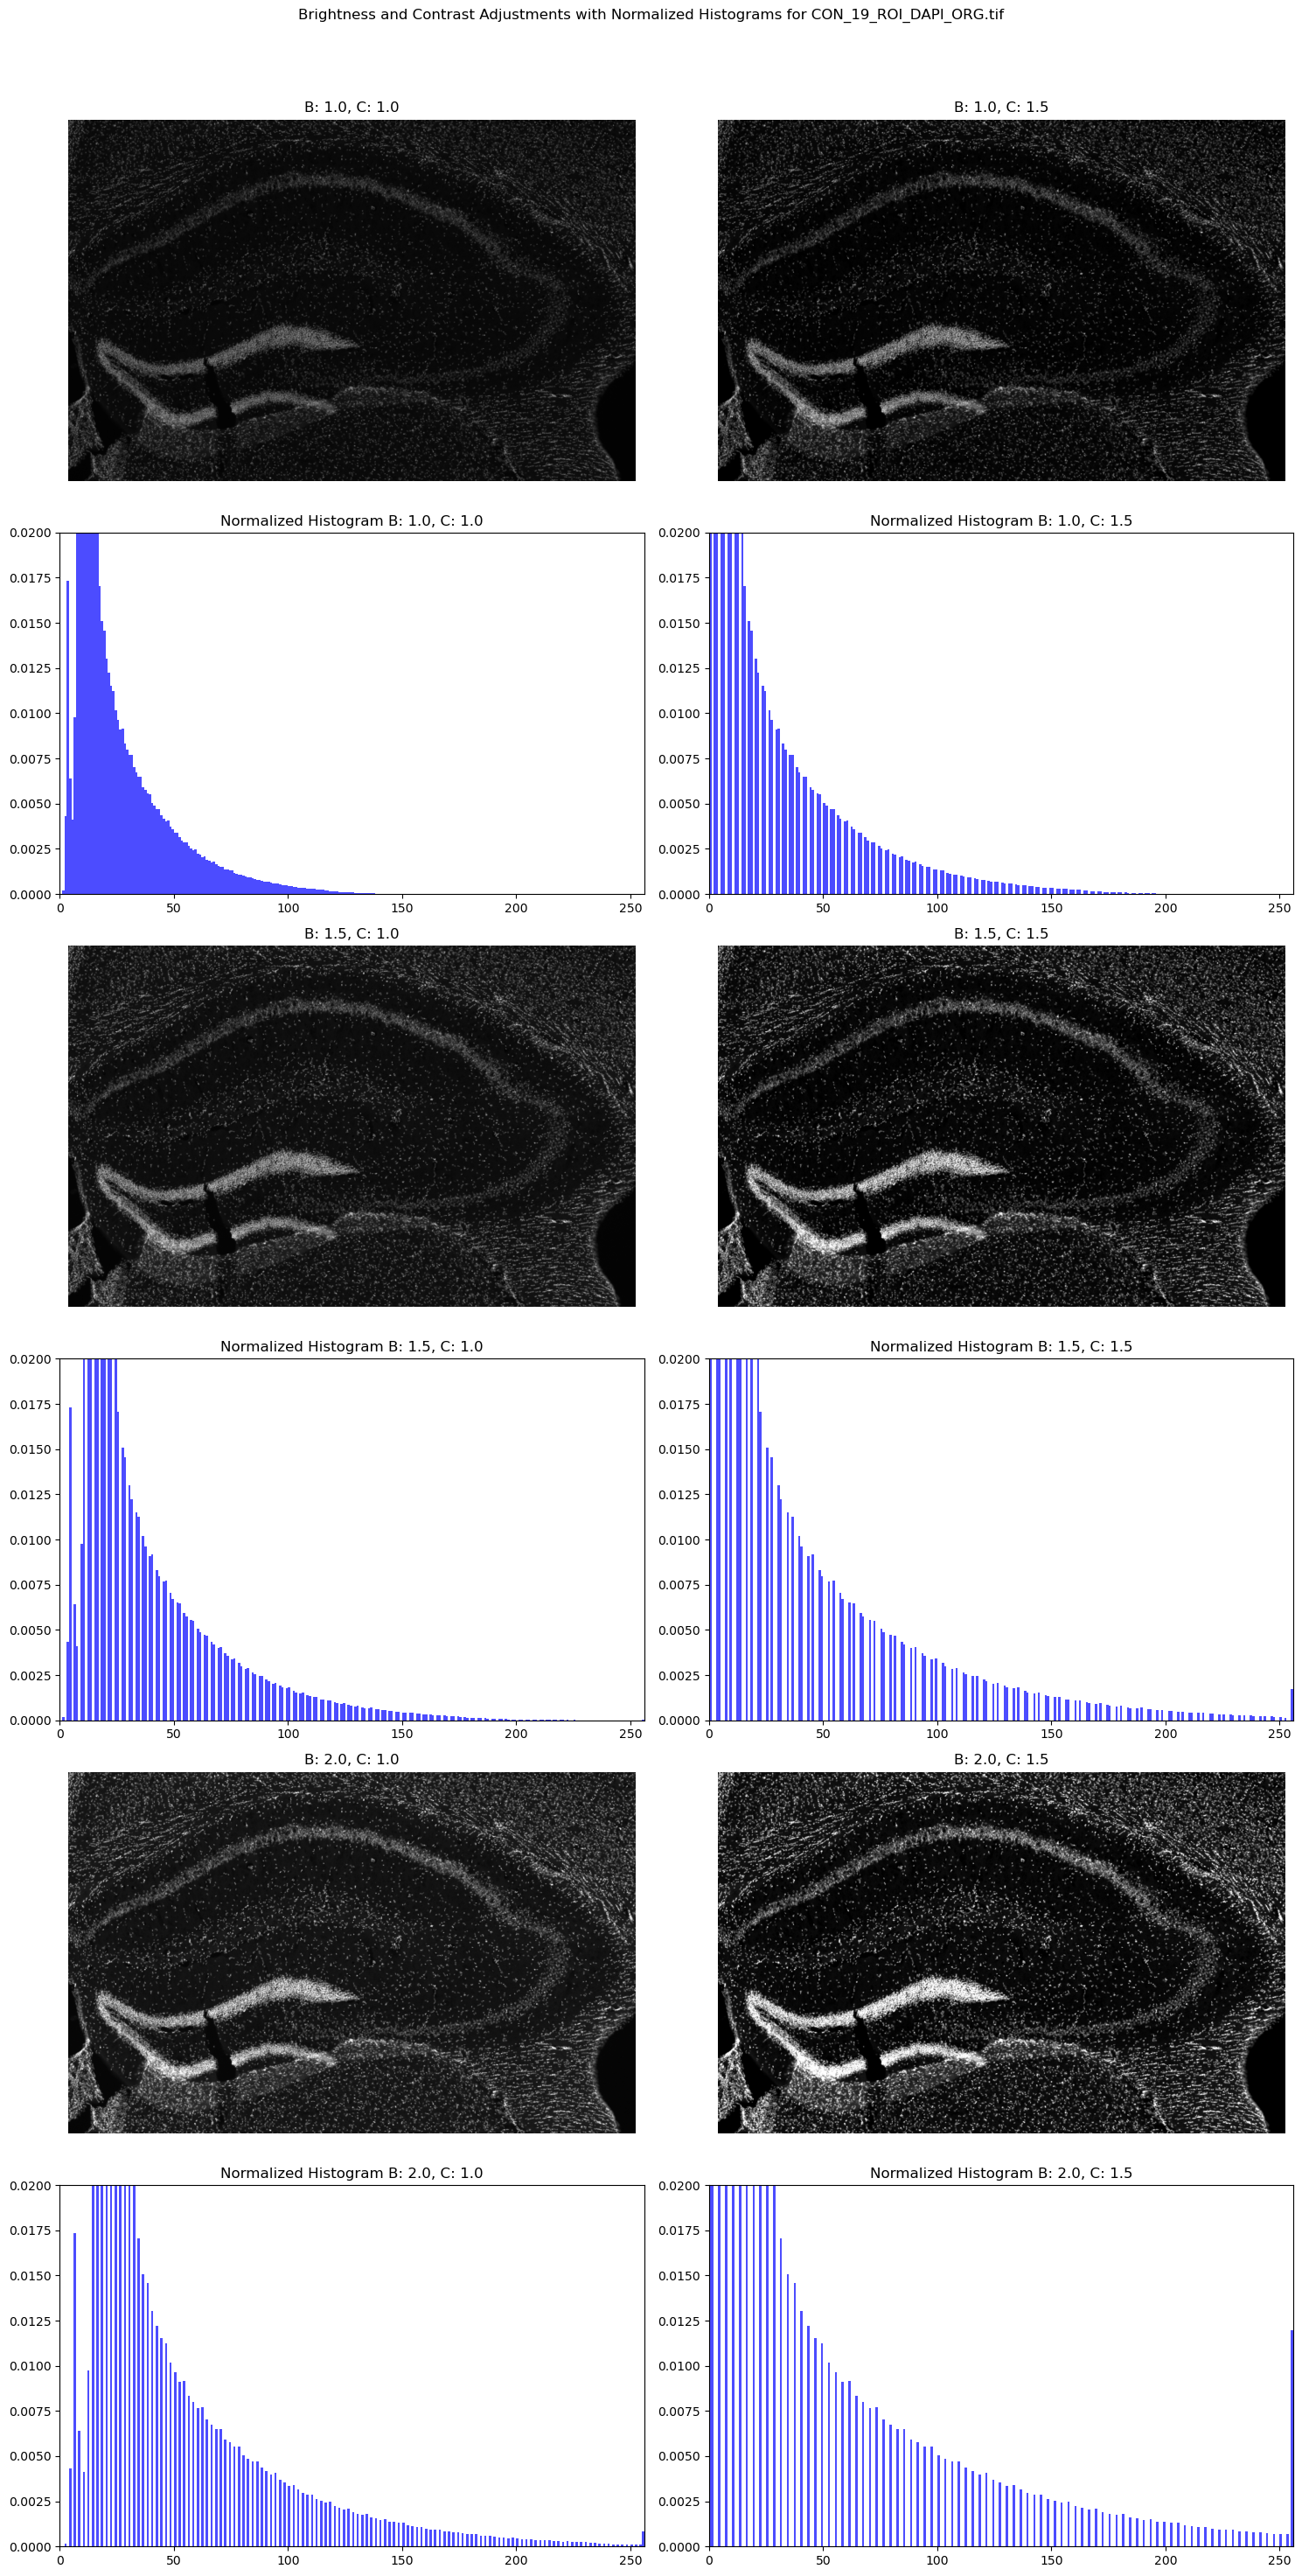

In [59]:
# Test usage
image_path = '/Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images'
brightness_factors = [1.0, 1.5, 2.0]
contrast_factors = [1.0, 1.5]
brightness_contrast_tester(image_path, brightness_factors, contrast_factors)

1.2.2 - Defining Function and Parameters (Image optimization batch processing)

Enhances the blue dye in DAPI scan TIFF images and saves the enhanced images.

Parameters:
input_dir (str): Directory containing the input TIFF images.
output_dir (str): Directory to save the enhanced TIFF images.
brightness_factor (float): Factor to adjust brightness. Default is 1.5.
contrast_factor (float): Factor to adjust contrast. Default is 1.5.

From 1.2.1, you will have identified the optimal Brightness and Contrast factors. Input these into the corresponding parameters

In [60]:
def enhance_dapi(input_dir, output_dir, brightness_factor=1.7, contrast_factor=1.7):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print(f"Input directory: {input_dir}")
    print(f"Output directory: {output_dir}")
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            file_path = os.path.join(input_dir, filename)
            image = Image.open(file_path)
            image_array = np.array(image)

            if len(image_array.shape) == 3 and image_array.shape[2] == 4:
                blue_channel = image_array[:, :, 2]
                blue_channel_enhanced = (blue_channel - blue_channel.min()) / (blue_channel.max() - blue_channel.min()) * 255
                blue_channel_enhanced = blue_channel_enhanced.astype(np.uint8)
                enhanced_image_array = np.zeros_like(image_array)
                enhanced_image_array[:, :, 2] = blue_channel_enhanced
                enhanced_image_array[:, :, 3] = 255
                enhanced_image = Image.fromarray(enhanced_image_array)
            else:
                enhanced_image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min()) * 255
                enhanced_image_array = enhanced_image_array.astype(np.uint8)
                enhanced_image = Image.fromarray(np.stack((enhanced_image_array,) * 3, axis=-1))
                enhanced_image = enhanced_image.convert("RGBA")

            # Adjust brightness
            enhancer = ImageEnhance.Brightness(enhanced_image)
            enhanced_image = enhancer.enhance(brightness_factor)

            # Adjust contrast
            enhancer = ImageEnhance.Contrast(enhanced_image)
            enhanced_image = enhancer.enhance(contrast_factor)

            enhanced_image_path = os.path.join(output_dir, filename)
            enhanced_image.save(enhanced_image_path)

            print(f"Enhanced image saved to: {enhanced_image_path}")


In [61]:
# Test Use
# For this Test, we will use the base DAPI images from "APOE 4" [Can be found in the example data directory]

input_directory = '/Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4'
output_directory = '/Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed'
enhance_dapi(input_directory, output_directory, brightness_factor=1.5, contrast_factor=1.5)

Input directory: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4
Output directory: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed
Enhanced image saved to: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Mouse_21_ROI_DAPI_ORG.tif
Enhanced image saved to: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Mouse_6_ROI_DAPI_ORG.tif
Enhanced image saved to: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Mouse_14_ROI_DAPI_ORG.tif
Enhanced image saved to: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Mouse_9_ROI_DAPI_ORG.tif
Enhanced image saved to: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Mouse_10_ROI_DAPI_ORG.tif
Enhanced image saved to: /Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/DOI_14_ROI_DAPI_ORG.tif
Enhanced image saved to: 

*It is important to note, that this function will be adapted according to corresponding "R" "G" "B" for other layers (protein/neurons etc.)*

**The images have been batch-processed and now ready for the boundary detection model**

## Stage 2 - Boundary Detection

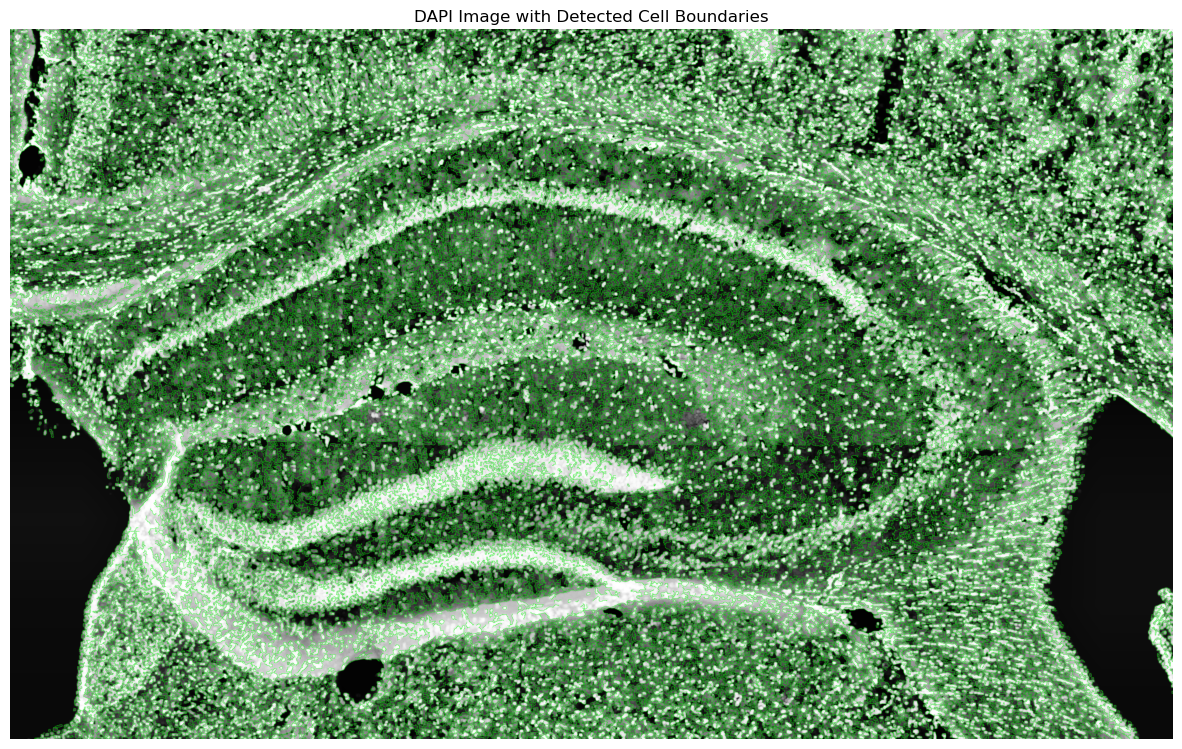

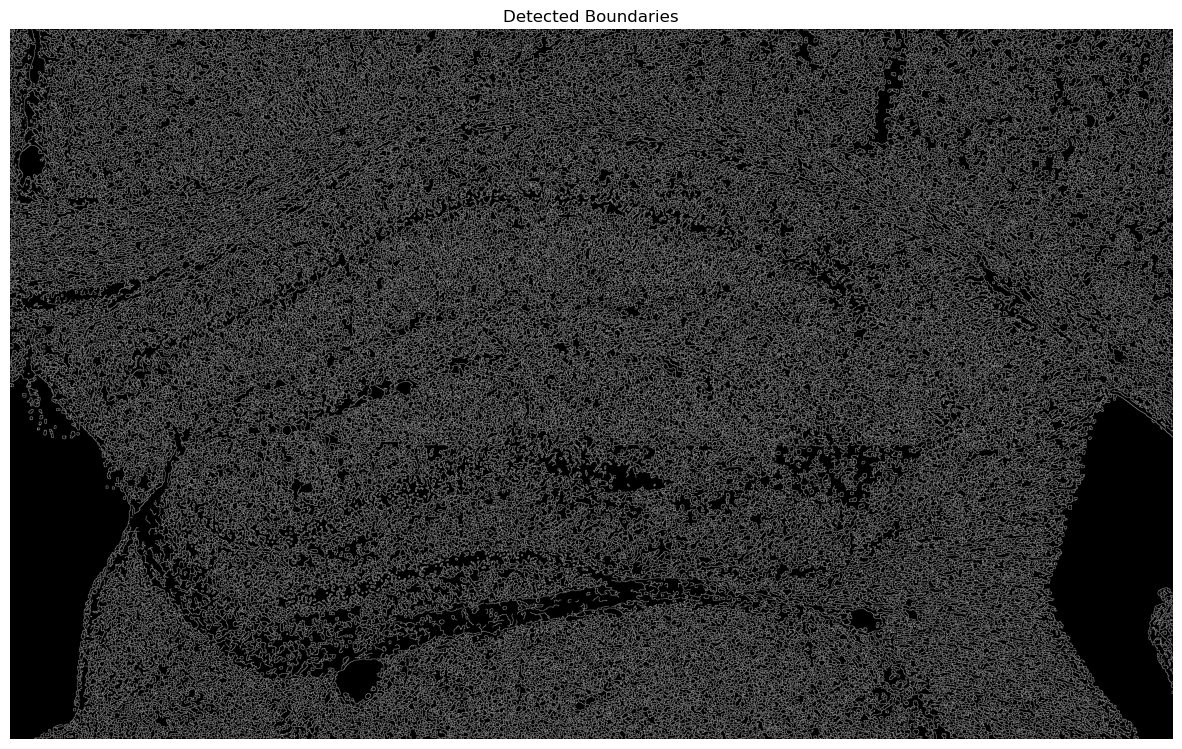

In [62]:
def preprocess_dapi_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was loaded correctly
    if image is None:
        raise ValueError(f"Could not load the image from the path: {image_path}")
    
    # Normalize the image intensity using histogram equalization
    normalized_image = exposure.equalize_hist(image) * 255
    normalized_image = normalized_image.astype(np.uint8)
    
    # Reduce noise with a Gaussian filter
    denoised_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)
    
    # Adjust contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(denoised_image)
    
    # Apply morphological operations to remove small noise
    kernel = np.ones((3, 3), np.uint8)
    morph_image = cv2.morphologyEx(enhanced_image, cv2.MORPH_OPEN, kernel, iterations=2)
    
    return morph_image

def detect_boundaries(image):
    # Apply Canny edge detection with adjusted parameters
    edges = cv2.Canny(image, 30, 100)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return edges, contours

def draw_contours(image, contours):
    # Convert to RGB to draw colored contours
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Draw contours
    cv2.drawContours(image_rgb, contours, -1, (0, 255, 0), 1)
    
    return image_rgb

# Example usage
input_image_path = '/Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Mouse_6_ROI_DAPI_ORG.tif'
preprocessed_image = preprocess_dapi_image(input_image_path)

# Detect boundaries
edges, contours = detect_boundaries(preprocessed_image)

# Draw contours on the original preprocessed image
image_with_contours = draw_contours(preprocessed_image, contours)

# Save the result
output_image_path = '/Users/shivgarge/Desktop/Root/Research/Neuro-Economics-ML/Images/APOE4_Processed/Test.tif'
cv2.imwrite(output_image_path, image_with_contours)

# Display the preprocessed image with contours
plt.figure(figsize=(15, 15))
plt.imshow(image_with_contours)
plt.title('DAPI Image with Detected Cell Boundaries')
plt.axis('off')
plt.show()

# Display the edges (boundaries only)
plt.figure(figsize=(15, 15))
plt.imshow(edges, cmap='gray')
plt.title('Detected Boundaries')
plt.axis('off')
plt.show()